Importing Required Libraries 

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Loading Eniac Data Frames

In [4]:
# orders_qu.csv
url = "https://drive.google.com/file/d/143CzG5DriVSPMkaL1UP4k3Y80oS8fgbV/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_qu = pd.read_csv(path)

# orderlines_qu.csv
url = "https://drive.google.com/file/d/1yWO-mQfxQtnSZdCgdNlIEUrZSCW1HN5O/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_qu = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

# brands.csv
url = "https://drive.google.com/file/d/1XGyabaa4mAkjixMk3XPgx_14OoSse3rs/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands = pd.read_csv(path)

Making Copy of Data Frames

In [5]:
orders_df = orders_qu.copy()
orderlines_df = orderlines_qu.copy()
products_df = products_cl.copy()
brands_df = brands.copy() 

Checking Content of Data Frames

In [6]:
display(orders_df.head(2))
display(orderlines_df.head(2))
display(products_df.head(2))
display(brands_df.head(2))

,order_id,created_date,total_paid,state
0,241423,2017-11-06 13:10:02,136.15,Completed
1,242832,2017-12-31 17:40:03,15.76,Completed


,id,id_order,product_id,product_quantity,sku,unit_price,date
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34


,sku,name,desc,price,in_stock,type
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696
1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,0,13855401


,short,long
0,8MO,8Mobility
1,ACM,Acme


Combining Data Frames 

In [7]:
# combining 'orders_df' and 'orderlines_df' on 'order_id'

orders_orderlines_df = orders_df.merge(orderlines_df,
                                       how = 'inner', 
                                       left_on = 'order_id', 
                                       right_on = 'id_order')


#dopping unwanted columns

orders_orderlines_df = orders_orderlines_df.drop(['created_date','state','id_order',
                                                  'product_id'], 
                                                 axis=1)


#rearranging columns

orders_orderlines_df = orders_orderlines_df[['id', 'order_id', 'date', 'sku',
                                             'unit_price', 'product_quantity', 
                                             'total_paid']]


#calculating discounts and adding that as a column

#merging 'orders_orderlines_df' with data frame 'products_df' to obtain listprice

orders_orderlines_products_df = orders_orderlines_df.merge(products_df,
                                       how = 'inner', 
                                       left_on = 'sku', 
                                       right_on = 'sku')



#to find out brands combining orders_orderlines_products_df with brands_df
#first creating short name of brands from 'sku' and adding it to orders_orderlines_products_df as column

orders_orderlines_products_df['short'] = orders_orderlines_products_df['sku'].str[:3]


#combining 'orders_orderlines_products_df' with 'brands_df' on 'short'

orders_orderlines_products_brands_df = orders_orderlines_products_df.merge(brands_df,
                                       how = 'inner', 
                                       left_on = 'short', 
                                       right_on = 'short')


#creating a data frame for discount analsys

discount_analsys_df = orders_orderlines_products_brands_df[['id','order_id','date','sku','long','unit_price','price','product_quantity','total_paid']]


discount_analsys = discount_analsys_df.copy()

#calculating discount, percentage discount and adding that to data frame 'discount_analsys'

discount_analsys.loc[:,'discount'] = discount_analsys_df['price'] - discount_analsys_df['unit_price']


#calculating and adding percentage discount to data frame 'discount_analsys'

discount_analsys.loc[:,'percentage_discount'] = ( discount_analsys['discount'] / discount_analsys['price'] ) * 100

#calculating and adding total price to data frame 'discount_analsys'

discount_analsys.loc[:,'total_price'] = ( discount_analsys['unit_price'] * discount_analsys['product_quantity'] ) 

#dropping negative discounts

discount_analsys = discount_analsys.drop(discount_analsys[discount_analsys.discount < 0].index)


#checking data types

discount_analsys.dtypes

#changing date format


discount_analsys['date']=pd.to_datetime(discount_analsys['date'])
discount_analsys.dtypes

#adding one more column with year and month

discount_analsys['Month_Year'] = pd.to_datetime(discount_analsys['date']).dt.strftime('%Y %m')
discount_analsys


#making a data frame with sum of total revenue grouped by month and year

discount_analsys_turnover_month = (
                         discount_analsys.groupby("Month_Year", as_index=False)
                         ["total_price"].sum()
                         )
#coverting date format in data frame 'discount_analsys_turnover_month' to month and year

discount_analsys_turnover_month['Month_Year'] = pd.to_datetime(discount_analsys_turnover_month['Month_Year']).dt.strftime('%b %Y')

#making another data frame with average 'percentage_discount'grouped by month and year

discount_analsys_percentage_discount = (
                         discount_analsys.groupby("Month_Year", as_index=False)
                         ["percentage_discount"].mean()
                         )
#coverting it's date to month and year

discount_analsys_percentage_discount['Month_Year'] = pd.to_datetime(discount_analsys_percentage_discount['Month_Year']).dt.strftime('%b %Y')

#merging the data frames 'discount_analsys_turnover_month' and 'discount_analsys_percentage_discount' on 'Month_Year' to get data frame 'discount_analsys_percentage_discount_turnover_month'

discount_analsys_percentage_discount_turnover_month = discount_analsys_turnover_month.merge(discount_analsys_percentage_discount, on = 'Month_Year')


#making another data frame with sum 'product_quantity' grouped by month and year

discount_analsys_quantity_month = (
                         discount_analsys.groupby("Month_Year", as_index=False)
                         ["product_quantity"].sum()
                         )

#coverting it's date to month and year

discount_analsys_quantity_month['Month_Year'] = pd.to_datetime(discount_analsys_quantity_month['Month_Year']).dt.strftime('%b %Y')

#merging the data frames 'discount_analsys_percentage_discount_turnover_month' and 'discount_analsys_quantity_month' on 'Month_Year' to get data frame 'discount_analsys_percentage_discount_turnover_quantity_month'

discount_analsys_percentage_discount_turnover_quantity_month = discount_analsys_percentage_discount_turnover_month.merge(discount_analsys_quantity_month, on = 'Month_Year')
discount_analsys_percentage_discount_turnover_quantity_month

,Month_Year,total_price,percentage_discount,product_quantity
0,Jan 2017,542742.05,26.397076,6545
1,Feb 2017,286394.88,21.433135,2710
2,Mar 2017,21004.59,21.935449,222
3,Apr 2017,214610.01,19.759597,2025
4,May 2017,297240.82,16.854426,2411
5,Jun 2017,249993.83,18.913913,1944
6,Jul 2017,559666.37,26.150166,4465
7,Aug 2017,356409.15,21.540440,2918
8,Sep 2017,376394.82,21.167543,2678
9,Oct 2017,531640.68,22.626459,3922


In [11]:
discount_analsys_percentage_discount_turnover_quantity_month.corr()

,total_price,percentage_discount,product_quantity
total_price,1.000000,0.191683,0.955085
percentage_discount,0.191683,1.000000,0.357820
product_quantity,0.955085,0.357820,1.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

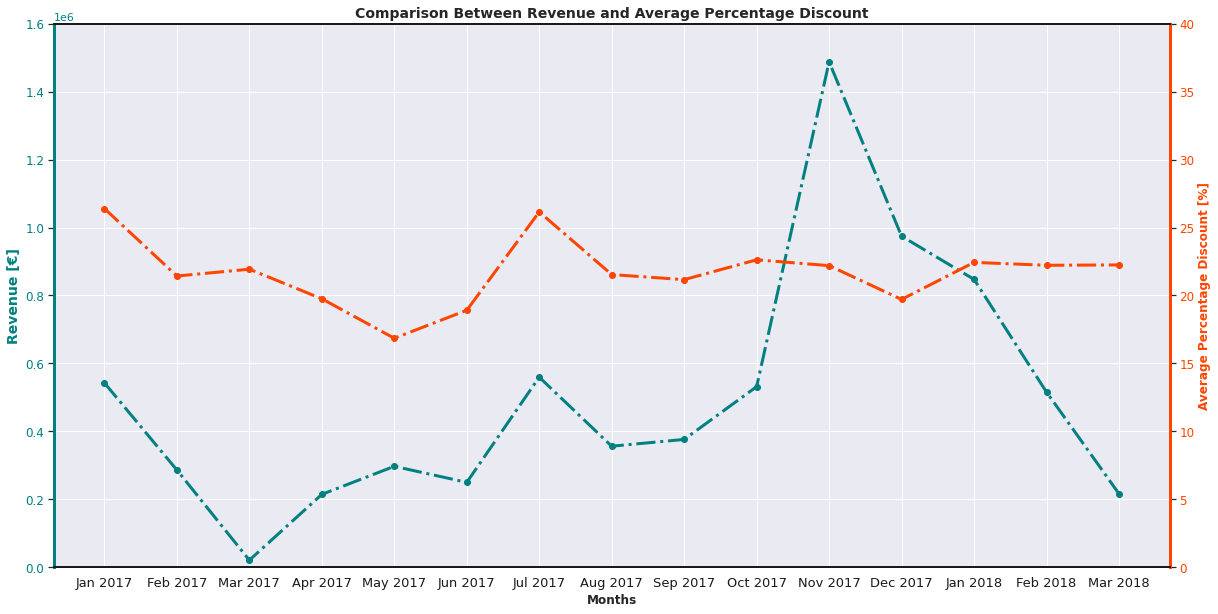

In [66]:
sns.set_style('darkgrid')

fig, ax1 = plt.subplots(figsize=(20, 10))

color1 = 'teal'
ax1.plot_date(data=discount_analsys_percentage_discount_turnover_quantity_month, x='Month_Year', y='total_price', color=color1,linestyle='-.', lw=3)
ax1.set_ylabel('Revenue [€]', color=color1, fontweight='bold', fontsize=14)
ax1.tick_params(axis='y', labelcolor=color1, labelsize=12)
ax1.tick_params(axis='x', labelcolor='k', labelsize=13)
plt.xlabel('Months', fontweight='bold', fontsize=12)
ax1.set_ylim(0, 1600000)
#ax1.get_ylim()

ax2 = ax1.twinx()

color2 = 'orangered'
ax2.plot_date(data=discount_analsys_percentage_discount_turnover_quantity_month, x="Month_Year", y="percentage_discount",color=color2,linestyle='-.', lw=3)
ax2.set_ylabel('Average Percentage Discount [%]', color=color2, fontweight='bold', fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=12)
ax2.set_ylim(0, 40)
ax2.grid(False)


plt.title('Comparison Between Revenue and Average Percentage Discount',fontweight='bold', fontsize=14)
ax2.spines['left'].set_color(color1)
ax2.spines['left'].set_linewidth(3)
ax2.spines['right'].set_color(color2)
ax2.spines['right'].set_linewidth(3)
ax2.spines['bottom'].set_color('k')
ax2.spines['top'].set_color('k')
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_linewidth(2)
# from google.colab import files
# plt.savefig("Revenue.png",dpi=400)
# files.download("Revenue.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

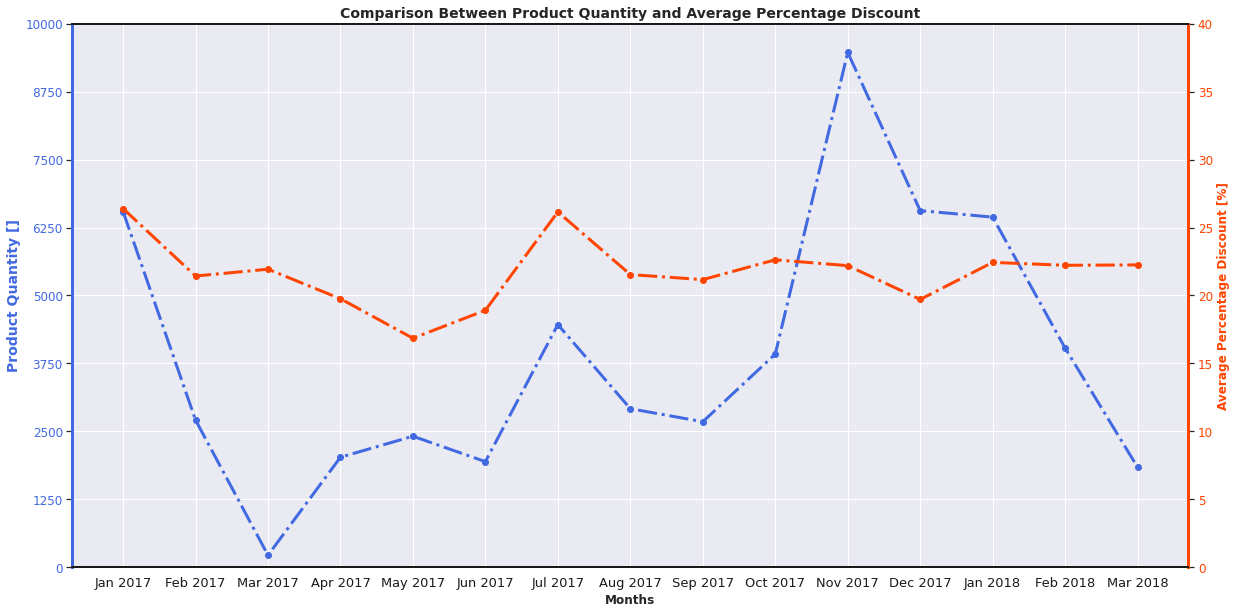

In [67]:
import matplotlib.ticker as ticker

sns.set_style('darkgrid')

fig, ax1 = plt.subplots(figsize=(20, 10))

color1 = 'royalblue'
ax1.plot_date(data=discount_analsys_percentage_discount_turnover_quantity_month, x='Month_Year', y='product_quantity', color=color1,linestyle='-.', lw=3)
ax1.set_ylabel('Product Quantity []', color=color1, fontweight='bold', fontsize=14)
ax1.tick_params(axis='y', labelcolor=color1, labelsize=12)
ax1.tick_params(axis='x', labelcolor='k', labelsize=13)
plt.xlabel('Months', fontweight='bold', fontsize=12)
ax1.set_ylim(0, 10000)
tick_spacing = 1250
ax1.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax2 = ax1.twinx()

color2 = 'orangered'
ax2.plot_date(data=discount_analsys_percentage_discount_turnover_quantity_month, x="Month_Year", y="percentage_discount",color=color2,linestyle='-.', lw=3)
ax2.set_ylabel('Average Percentage Discount [%]', color=color2, fontweight='bold', fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=12)
ax2.set_ylim(0, 40)
ax2.grid(False)


plt.title('Comparison Between Product Quantity and Average Percentage Discount',fontweight='bold', fontsize=14)
ax2.spines['left'].set_color(color1)
ax2.spines['left'].set_linewidth(3)
ax2.spines['right'].set_color(color2)
ax2.spines['right'].set_linewidth(3)
ax2.spines['bottom'].set_color('k')
ax2.spines['top'].set_color('k')
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_linewidth(2)
# from google.colab import files
# plt.savefig("Quantity.png",dpi=400)
# files.download("Quantity.png")
plt.show()



In [ ]:
from pandas.core.reshape.merge import merge
discount_analsys['percentage_discount_category'] = np.where(discount_analsys['percentage_discount'] >30, '31-100',
                                          np.where(discount_analsys['percentage_discount'] > 25, '26 - 30',
                                          np.where(discount_analsys['percentage_discount'] > 20, '21 - 25',
                                          np.where(discount_analsys['percentage_discount'] > 15, '16 - 20',
                                          np.where(discount_analsys['percentage_discount'] > 10, '11 - 15',
                                          np.where(discount_analsys['percentage_discount'] > 5, '06 - 10','00-05'))))))


discount_analsys_discount_cat_revenue = (
                         discount_analsys.groupby("percentage_discount_category", as_index=False)
                         ["total_price"].sum()
                         )
discount_analsys_discount_cat_revenue['percentage_total_price'] = (discount_analsys_discount_cat_revenue['total_price'] / discount_analsys_discount_cat_revenue['total_price'].sum()) * 100


discount_analsys_discount_cat_quantity= (
                         discount_analsys.groupby("percentage_discount_category", as_index=False)
                         ["product_quantity"].sum()
                         )
discount_analsys_discount_cat_quantity['percentage_product_quantity'] = (discount_analsys_discount_cat_quantity['product_quantity'] / discount_analsys_discount_cat_quantity['product_quantity'].sum()) * 100

discount_analsys_discount_cat_revenue_quantity = discount_analsys_discount_cat_revenue.merge(discount_analsys_discount_cat_quantity, on ='percentage_discount_category')


discount_analsys_discount_cat_revenue_quantity1 = discount_analsys_discount_cat_revenue_quantity[['percentage_discount_category','percentage_total_price','percentage_product_quantity']]
discount_analsys_discount_cat_revenue_quantity1.set_index("percentage_discount_category", inplace = True)
discount_analsys_discount_cat_revenue_quantity1

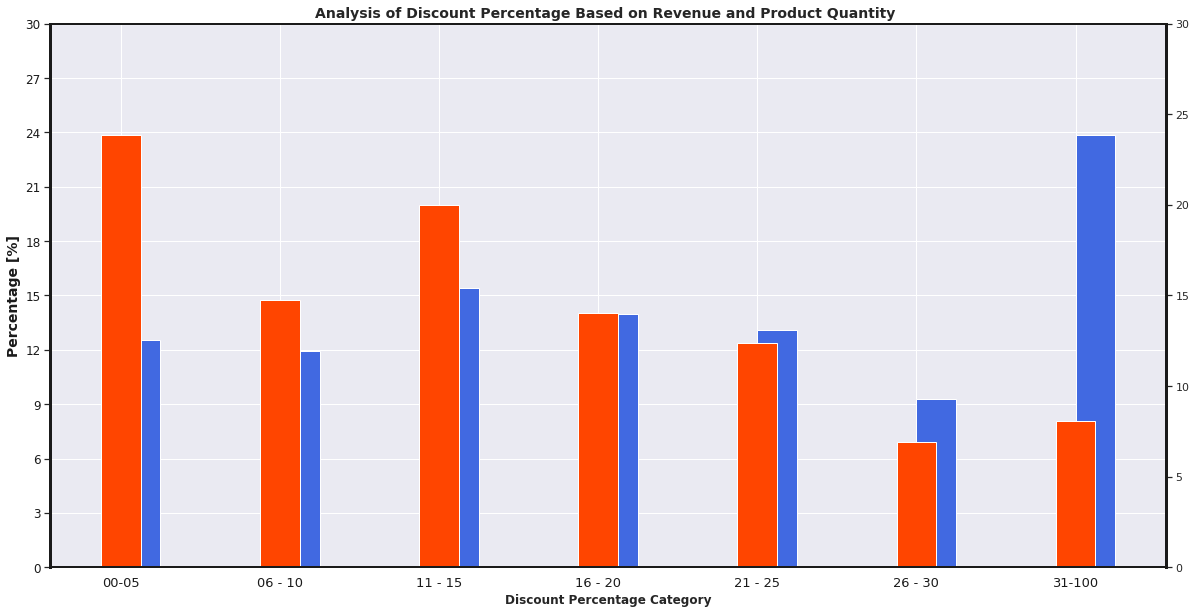

In [16]:
import matplotlib.ticker as ticker

sns.set_style('darkgrid')


#df = discount_analsys_discount_cat_revenue_quantity

fig, ax1 = plt.subplots(figsize=(20, 10))

x = np.arange(len(list(discount_analsys_discount_cat_revenue_quantity.percentage_discount_category)))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
color0 = 'k'
color1 = 'royalblue'
ax1.bar(list(discount_analsys_discount_cat_revenue_quantity.percentage_discount_category), list(discount_analsys_discount_cat_revenue_quantity.percentage_product_quantity),width, color=color1,align='edge')
ax1.set_ylabel('Percentage [%]', color=color0, fontweight='bold', fontsize=14)
ax1.tick_params(axis='y', labelcolor=color0, labelsize=12)
ax1.tick_params(axis='x', labelcolor=color0, labelsize=13)
plt.xlabel('Discount Percentage Category', fontweight='bold', fontsize=12)
ax1.set_ylim(0, 30)
tick_spacing_ax1 = 3
ax1.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_ax1))

ax2 = ax1.twinx()

color2 = 'orangered'
ax2.bar(list(discount_analsys_discount_cat_revenue_quantity.percentage_discount_category), list(discount_analsys_discount_cat_revenue_quantity.percentage_total_price),width,color=color2,align='center')
#ax2.set_ylabel('Average Percentage Discount [%]', color=color2, fontweight='bold', fontsize=12)
#ax2.tick_params(axis='y', labelcolor=color2, labelsize=12)
ax2.set_ylim(0, 30)
#tick_spacing_ax2 = 3
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_ax2))
ax2.grid(False)




plt.title('Analysis of Discount Percentage Based on Revenue and Product Quantity ',fontweight='bold', fontsize=14)
ax2.spines['left'].set_color(color0)
ax2.spines['left'].set_linewidth(3)
ax2.spines['right'].set_color(color0)
ax2.spines['right'].set_linewidth(3)
ax2.spines['bottom'].set_color(color0)
ax2.spines['top'].set_color(color0)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['top'].set_linewidth(2)
plt.show()

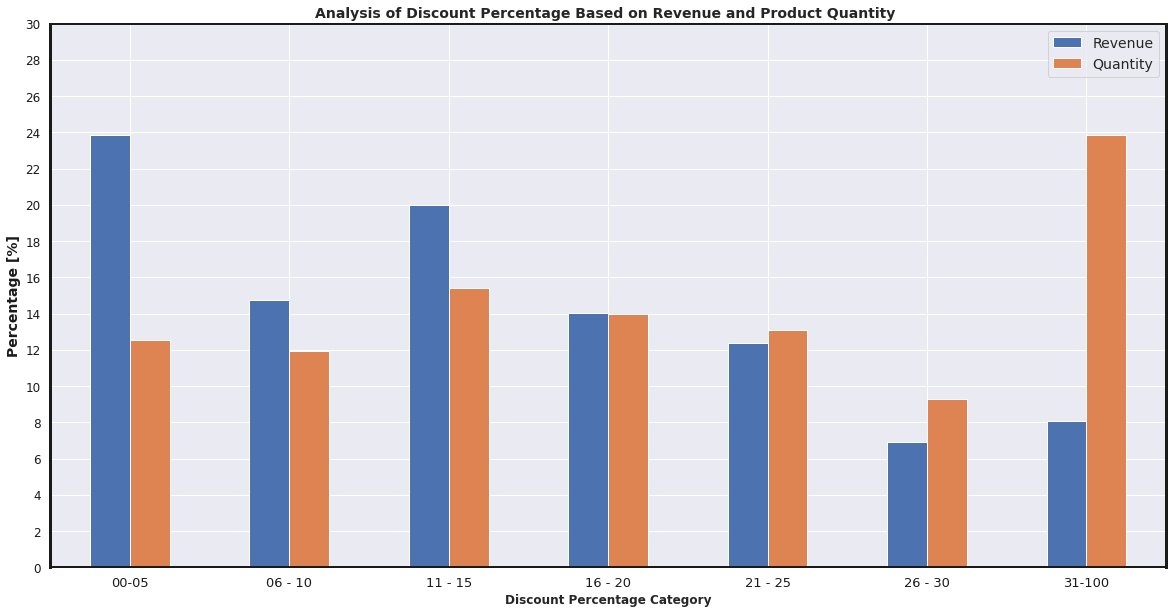

In [17]:

sns.set_style('darkgrid')



color0 = 'k'
color1 = 'royalblue'
ax = discount_analsys_discount_cat_revenue_quantity1.plot.bar(rot=0, figsize=(20, 10))
ax.set_ylabel('Percentage [%]', color=color0, fontweight='bold', fontsize=14)
ax.tick_params(axis='y', labelcolor=color0, labelsize=12)
ax.tick_params(axis='x', labelcolor=color0, labelsize=13)
plt.xlabel('Discount Percentage Category', fontweight='bold', fontsize=12)
ax.set_ylim(0, 30)
tick_spacing_ax = 2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_ax))

plt.title('Analysis of Discount Percentage Based on Revenue and Product Quantity ',fontweight='bold', fontsize=14)
ax.spines['left'].set_color(color0)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_color(color0)
ax.spines['right'].set_linewidth(3)
ax.spines['bottom'].set_color(color0)
ax.spines['top'].set_color(color0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

legend_labels = ['Revenue', 'Quantity']
plt.legend(legend_labels,loc=1,prop={'size': 14})


plt.show()

In [28]:
from pandas.core.reshape.merge import merge
discount_analsys_test01 = discount_analsys.copy()
discount_analsys_test01['percentage_discount_category'] = np.where(discount_analsys_test01['percentage_discount'] > 80, '81 - 100',
                                                                   np.where(discount_analsys_test01['percentage_discount'] > 60, '61 - 80',
                                                                   np.where(discount_analsys_test01['percentage_discount'] > 50, '51 - 60',
                                                                   np.where(discount_analsys_test01['percentage_discount'] >40, '41-50',
                                                                   np.where(discount_analsys_test01['percentage_discount'] >30, '31-40',
                                                                   np.where(discount_analsys_test01['percentage_discount'] > 25, '26 - 30',
                                                                   np.where(discount_analsys_test01['percentage_discount'] > 20, '21 - 25',
                                                                   np.where(discount_analsys_test01['percentage_discount'] > 15, '16 - 20',
                                                                   np.where(discount_analsys_test01['percentage_discount'] > 10, '11 - 15',
                                                                   np.where(discount_analsys_test01['percentage_discount'] > 5, '06 - 10','00-05'))))))))))


discount_analsys_discount_cat_revenue_test01 = (
                         discount_analsys_test01.groupby("percentage_discount_category", as_index=False)
                         ["total_price"].sum()
                         )
discount_analsys_discount_cat_revenue_test01['percentage_total_price'] = (discount_analsys_discount_cat_revenue_test01['total_price'] / discount_analsys_discount_cat_revenue_test01['total_price'].sum()) * 100


discount_analsys_discount_cat_quantity_test01= (
                         discount_analsys_test01.groupby("percentage_discount_category", as_index=False)
                         ["product_quantity"].sum()
                         )
discount_analsys_discount_cat_avg_price_test01= (
                          discount_analsys_test01.groupby("percentage_discount_category", as_index=False)
                          ["total_price"].mean()
                         )

discount_analsys_discount_cat_quantity_test01['percentage_product_quantity'] = (discount_analsys_discount_cat_quantity_test01['product_quantity'] / discount_analsys_discount_cat_quantity_test01['product_quantity'].sum()) * 100

discount_analsys_discount_cat_revenue_quantity_test01 = discount_analsys_discount_cat_revenue_test01.merge(discount_analsys_discount_cat_quantity_test01, on ='percentage_discount_category')
discount_analsys_discount_cat_revenue_quantity_test01
discount_analsys_discount_cat_revenue_quantity_avg_price_test01=discount_analsys_discount_cat_revenue_quantity_test01.merge(discount_analsys_discount_cat_avg_price_test01, on ='percentage_discount_category')
discount_analsys_discount_cat_revenue_quantity_avg_price_test01['avg_product_price'] = (discount_analsys_discount_cat_revenue_quantity_avg_price_test01['total_price_y']/discount_analsys_discount_cat_revenue_quantity_avg_price_test01['total_price_y'].sum())*100
discount_analsys_discount_cat_revenue_quantity_avg_price_test01
discount_analsys_discount_cat_revenue_quantity1_test01 = discount_analsys_discount_cat_revenue_quantity_avg_price_test01[['percentage_discount_category','percentage_total_price','percentage_product_quantity','avg_product_price']]
discount_analsys_discount_cat_revenue_quantity1_test01.set_index("percentage_discount_category", inplace = True)
discount_analsys_discount_cat_revenue_quantity1_test01

discount_analsys_discount_cat_quantity_test01

,percentage_discount_category,product_quantity,percentage_product_quantity
0,00-05,7310,12.562944
1,06 - 10,6930,11.909877
2,11 - 15,8955,15.390036
3,16 - 20,8121,13.956726
4,21 - 25,7609,13.076804
5,26 - 30,5389,9.261519
6,31-40,4989,8.574080
7,41-50,3102,5.331088
8,51 - 60,2249,3.865125
9,61 - 80,3149,5.411862


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 60000x30000 with 0 Axes>

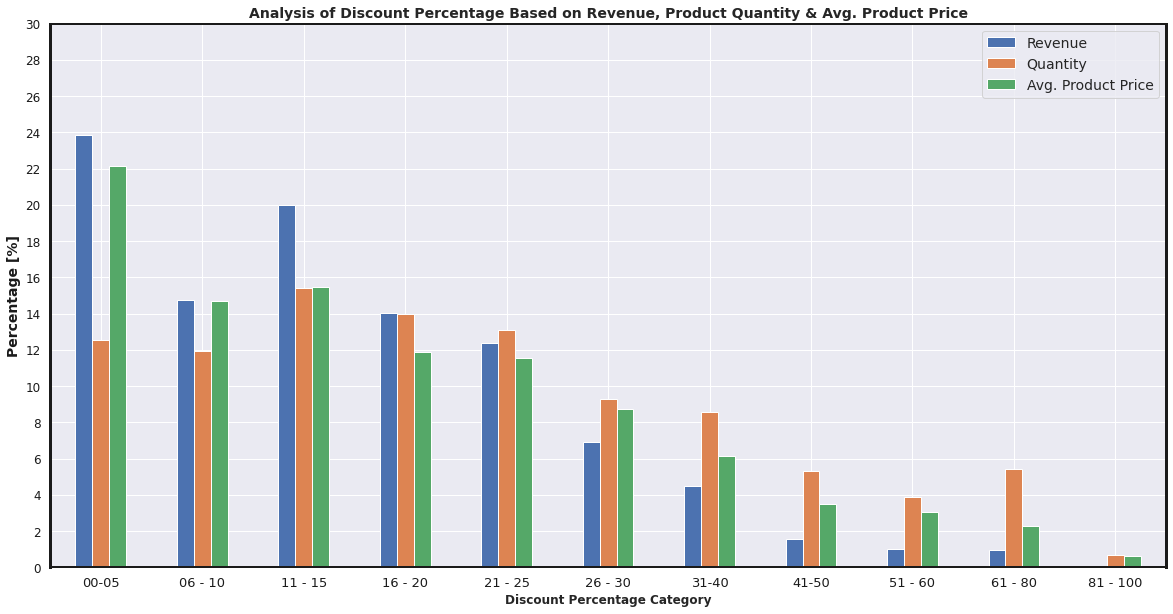

In [68]:

from matplotlib.pyplot import figure

figure(figsize=(20, 10), dpi=3000)

sns.set_style('darkgrid')



color0 = 'k'
color1 = 'royalblue'
ax = discount_analsys_discount_cat_revenue_quantity1_test01.plot.bar(rot=0, figsize=(20, 10))
ax.set_ylabel('Percentage [%]', color=color0, fontweight='bold', fontsize=14)
ax.tick_params(axis='y', labelcolor=color0, labelsize=12)
ax.tick_params(axis='x', labelcolor=color0, labelsize=13)
plt.xlabel('Discount Percentage Category', fontweight='bold', fontsize=12)
ax.set_ylim(0, 30)
tick_spacing_ax = 2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_ax))

plt.title('Analysis of Discount Percentage Based on Revenue, Product Quantity & Avg. Product Price',fontweight='bold', fontsize=14)
ax.spines['left'].set_color(color0)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_color(color0)
ax.spines['right'].set_linewidth(3)
ax.spines['bottom'].set_color(color0)
ax.spines['top'].set_color(color0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

legend_labels = ['Revenue', 'Quantity','Avg. Product Price']
plt.legend(legend_labels,loc=1,prop={'size': 14})

# from google.colab import files
# plt.savefig("Discount_Cat.png",dpi=400)
# files.download("Discount_Cat.png")

plt.show()

 

In [21]:
from pandas.core.reshape.merge import merge
discount_analsys_test02 = discount_analsys.copy()
discount_analsys_test03=discount_analsys_test02.drop(discount_analsys_test02[discount_analsys_test02.Month_Year == '2017 11'].index)
discount_analsys_test03=discount_analsys_test03.drop(discount_analsys_test02[discount_analsys_test02.Month_Year == '2017 12'].index)

discount_analsys_test03['percentage_discount_category'] = np.where(discount_analsys_test03['percentage_discount'] > 80, '81 - 100',
                                                                   np.where(discount_analsys_test03['percentage_discount'] > 60, '61 - 80',
                                                                   np.where(discount_analsys_test03['percentage_discount'] > 50, '51 - 60',
                                                                   np.where(discount_analsys_test03['percentage_discount'] >40, '41-50',
                                                                   np.where(discount_analsys_test03['percentage_discount'] >30, '31-40',
                                                                   np.where(discount_analsys_test03['percentage_discount'] > 25, '26 - 30',
                                                                   np.where(discount_analsys_test03['percentage_discount'] > 20, '21 - 25',
                                                                   np.where(discount_analsys_test03['percentage_discount'] > 15, '16 - 20',
                                                                   np.where(discount_analsys_test03['percentage_discount'] > 10, '11 - 15',
                                                                   np.where(discount_analsys_test03['percentage_discount'] > 5, '06 - 10','00-05'))))))))))


discount_analsys_discount_cat_revenue_test03 = (
                         discount_analsys_test03.groupby("percentage_discount_category", as_index=False)
                         ["total_price"].sum()
                         )
discount_analsys_discount_cat_revenue_test03['percentage_total_price'] = (discount_analsys_discount_cat_revenue_test03['total_price'] / discount_analsys_discount_cat_revenue_test03['total_price'].sum()) * 100


discount_analsys_discount_cat_quantity_test03= (
                         discount_analsys_test03.groupby("percentage_discount_category", as_index=False)
                         ["product_quantity"].sum()
                         )
discount_analsys_discount_cat_avg_price_test03= (
                          discount_analsys_test03.groupby("percentage_discount_category", as_index=False)
                          ["total_price"].mean()
                         )

discount_analsys_discount_cat_quantity_test03['percentage_product_quantity'] = (discount_analsys_discount_cat_quantity_test03['product_quantity'] / discount_analsys_discount_cat_quantity_test03['product_quantity'].sum()) * 100

discount_analsys_discount_cat_revenue_quantity_test03 = discount_analsys_discount_cat_revenue_test03.merge(discount_analsys_discount_cat_quantity_test03, on ='percentage_discount_category')
discount_analsys_discount_cat_revenue_quantity_test03
discount_analsys_discount_cat_revenue_quantity_avg_price_test03=discount_analsys_discount_cat_revenue_quantity_test03.merge(discount_analsys_discount_cat_avg_price_test03, on ='percentage_discount_category')
discount_analsys_discount_cat_revenue_quantity_avg_price_test03['avg_product_price'] = (discount_analsys_discount_cat_revenue_quantity_avg_price_test03['total_price_y']/discount_analsys_discount_cat_revenue_quantity_avg_price_test03['total_price_y'].sum())*100
discount_analsys_discount_cat_revenue_quantity_avg_price_test03
discount_analsys_discount_cat_revenue_quantity1_test03 = discount_analsys_discount_cat_revenue_quantity_avg_price_test03[['percentage_discount_category','percentage_total_price','percentage_product_quantity','avg_product_price']]
discount_analsys_discount_cat_revenue_quantity1_test03.set_index("percentage_discount_category", inplace = True)
discount_analsys_discount_cat_revenue_quantity1_test03


,percentage_total_price,percentage_product_quantity,avg_product_price
percentage_discount_category,,,
00-05,23.450168,13.211083,20.681183
06 - 10,15.170310,12.390283,14.403708
11 - 15,20.039114,14.753048,15.893796
16 - 20,14.015380,13.533710,12.081241
21 - 25,12.372364,12.712910,11.673904
26 - 30,5.991961,7.887745,8.806208
31-40,4.586159,8.442852,6.303184
41-50,1.830062,5.717132,3.731928
51 - 60,1.267577,4.578450,3.243545


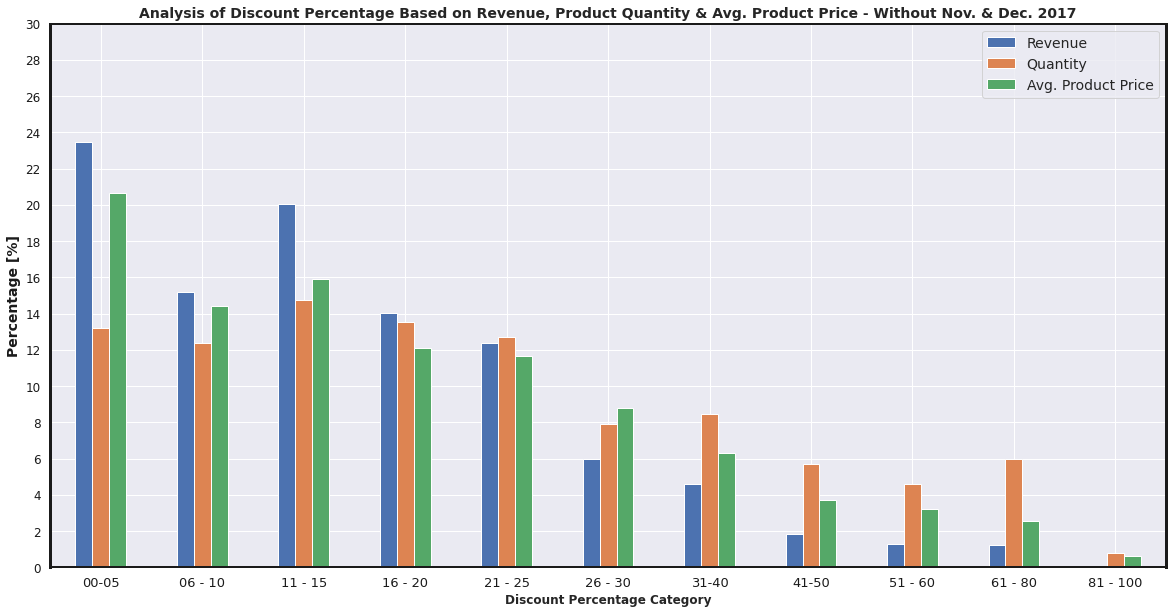

In [22]:

sns.set_style('darkgrid')



color0 = 'k'
color1 = 'royalblue'
ax = discount_analsys_discount_cat_revenue_quantity1_test03.plot.bar(rot=0, figsize=(20, 10))
ax.set_ylabel('Percentage [%]', color=color0, fontweight='bold', fontsize=14)
ax.tick_params(axis='y', labelcolor=color0, labelsize=12)
ax.tick_params(axis='x', labelcolor=color0, labelsize=13)
plt.xlabel('Discount Percentage Category', fontweight='bold', fontsize=12)
ax.set_ylim(0, 30)
tick_spacing_ax = 2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_ax))

plt.title('Analysis of Discount Percentage Based on Revenue, Product Quantity & Avg. Product Price - Without Nov. & Dec. 2017',fontweight='bold', fontsize=14)
ax.spines['left'].set_color(color0)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_color(color0)
ax.spines['right'].set_linewidth(3)
ax.spines['bottom'].set_color(color0)
ax.spines['top'].set_color(color0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

legend_labels = ['Revenue', 'Quantity','Avg. Product Price']
plt.legend(legend_labels,loc=1,prop={'size': 14})


plt.show()

In [23]:
discount_analsys.dtypes

id                                       int64
order_id                                 int64
date                            datetime64[ns]
sku                                     object
long                                    object
unit_price                             float64
price                                  float64
product_quantity                         int64
total_paid                             float64
discount                               float64
percentage_discount                    float64
total_price                            float64
Month_Year                              object
percentage_discount_category            object
dtype: object

In [70]:


regexp_dict = {
    'Accessories':'11905404|5384|1296|13855401|5398|1229|1387|2449|5720|9094|5401|5405|1216|1375|1424|54025401',
    'Adapters/Cables/Power':'12585395|1230|1325|12755395|13615399|10142|12995397|13005399|1515|5395|24215399|14365395|5399|54085407|13955395|15435404',
    'Apple TV':'4259| 113464259',
    'Apple Watch':'24895185|24885185',
    'Bag': '1392| 10230',
    'Case': '11865403|13835403|13555403|12635403|12575403|2425|5403|2434|14035403|5,49E+11|54864259',
    'iMac': '1282|51882158|5,72E+15|5,43E+15|2,16E+11',
    'iPad':'1714|106431714|51871714|13621714|12141714|42931714|51861714|24861714|12051714|12031714|113851714',
    'iPhone':'51601716|21561716|113291716|85641716|113281716|85651716|24821716|24811716|21571716|1716|113271716',
    'iPod':'11821715|79201715',
    'Mac':'21622158|5,44E+11|5,45E+15',
    'Memory': '11935397|1364|12215397|12655397|42945397|1433|57445397|1276',
    'Other': '12175397|1298|8696|1334|1404|5404|12355400|1416|20642062|1280|11859|11434',
    'Reapirs/Care/Warranty':'1231|14305406|12645406|21485407|101781405|12085400|5407|21535407|12285400|1,44E+11|5406',
    'Tablet':'1405',
    'Macbook':'2,17E+11'
}


for i in regexp_dict:
  discount_analsys_test04.loc[(discount_analsys_test04["type"].str.contains(regexp_dict[i])),'Product_Category']  = i

In [ ]:
discount_analsys_test04 =  discount_analsys.copy()
discount_analsys_test04 = discount_analsys_test04.merge(products_df,on = 'sku')
discount_analsys_test04['Product_Category'] = ''

discount_analsys_test04 = discount_analsys_test04[discount_analsys_test04['type'].notna()]
discount_analsys_test04









In [ ]:
discount_analsys_test04_group_revenue= (
                          discount_analsys_test04.groupby("long", as_index=False)["percentage_discount"].mean().nlargest(10,'percentage_discount')
                         )
discount_analsys_test04_group_revenue